In [884]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyedflib
import mne
import neurokit2 as nk2
import p_tqdm
from scipy.stats import trim_mean
from scipy import signal
from scipy.optimize import least_squares
import statsmodels.api as sm
from collections import defaultdict
import wfdb
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import RANSACRegressor
from scipy.interpolate import interp1d

In [2]:
#Desired Outcome..Preproccessed Data

result, fields = wfdb.rdsamp('x001')
header=fields['sig_name']
desired_result=pd.DataFrame(data=result, columns=header)

#Raw Data

s1_polar=pd.read_csv('/Users/jaredperez/Multiple Physiological Measurements at Different Loads/x001_POLAR.hrm', 
                     on_bad_lines='skip', names=['R-R Interval (ms)'])

edf_HX = mne.io.read_raw_edf('x001_HX.edf')
edf_HX=edf_HX.to_data_frame()

edf_NEXUS=mne.io.read_raw_edf('x001_NEXUS.edf')
edf_NEXUS_df=edf_NEXUS.to_data_frame()
edf_NEXUS_df['Sensor-B:EKG']=edf_NEXUS_df['Sensor-B:EEG']
edf_NEXUS_df=edf_NEXUS_df.drop(columns='Sensor-B:EEG') #Removing misnamed column

edf_SOT=mne.io.read_raw_edf('x001_SOT.edf')
edf_SOT_df=edf_SOT.to_data_frame()

edf_FAROS=mne.io.read_raw_edf('x001_FAROS.edf')
edf_FAROS_df=edf_FAROS.to_data_frame()

Extracting EDF parameters from /Users/jaredperez/Multiple Physiological Measurements at Different Loads/x001_HX.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /Users/jaredperez/Multiple Physiological Measurements at Different Loads/x001_NEXUS.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /Users/jaredperez/Multiple Physiological Measurements at Different Loads/x001_SOT.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /Users/jaredperez/Multiple Physiological Measurements at Different Loads/x001_FAROS.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


# View all Sensor Data

In [3]:
edf_HX

,time,4113:ECG_I,19:heart_rate,33:breathing_rat,4129:resp_thorac,4130:resp_abdomi,49:activity,4146:accel_Y,4147:accel_Z,4145:accel_X,53:cadence,1000:heart_rate_,1001:breathing_r
0,0.000000,1900.842412,0.0,0.0,0.000000e+00,0.000000e+00,-46.875715,89796.841382,-9.766090e+05,-164109.315633,0.0,0.0,0.0
1,0.003906,-8697.550007,0.0,0.0,-2.827944e+09,-1.964988e+09,-46.875715,250058.089245,-1.275097e+06,-155396.539610,0.0,0.0,0.0
2,0.007812,-8703.950002,0.0,0.0,0.000000e+00,0.000000e+00,-46.875715,313964.042753,-1.372712e+06,-105322.003073,0.0,0.0,0.0
3,0.011719,-8703.950002,0.0,0.0,1.013252e+09,7.796086e+08,-46.875715,269286.523103,-1.241435e+06,-51353.428274,0.0,0.0,0.0
4,0.015625,-8703.950002,0.0,0.0,0.000000e+00,0.000000e+00,-46.875715,124953.078508,-9.219215e+05,-23484.367132,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
896507,3501.980469,-8703.950002,0.0,26000000.0,0.000000e+00,0.000000e+00,128859.327077,-46.875715,-4.687572e+01,-46.875715,0.0,0.0,15000000.0
896508,3501.984375,-8703.950002,0.0,26000000.0,0.000000e+00,0.000000e+00,128859.327077,-46.875715,-4.687572e+01,-46.875715,0.0,0.0,15000000.0
896509,3501.988281,-8703.950002,0.0,26000000.0,0.000000e+00,0.000000e+00,128859.327077,-46.875715,-4.687572e+01,-46.875715,0.0,0.0,15000000.0
896510,3501.992188,-8703.950002,0.0,26000000.0,0.000000e+00,0.000000e+00,128859.327077,-46.875715,-4.687572e+01,-46.875715,0.0,0.0,15000000.0


In [4]:
edf_SOT_df

,time,Akku,EKG 3,aVL,EKG,EKG2,SpO2,Pleth,aVR,EKG 1,aVF,Aktivitt,Krperlage,Puls
0,0.000000,0.0,1.465201,-2694.505495,-5390.476190,-5390.476190,0.000000e+00,8.526513e-08,5393.406593,-5390.476190,-2694.505495,3.552714e-09,5000000.0,0.000000e+00
1,0.001953,0.0,1.465201,-2228.571429,-4461.538462,-4461.538462,-5.452437e+05,-6.366244e+07,4461.538462,-4461.538462,-2228.571429,-6.124206e+05,5000000.0,-5.341162e+05
2,0.003906,0.0,1.465201,-2043.956044,-4092.307692,-4092.307692,-1.081186e+06,2.842171e-08,4092.307692,-4092.307692,-2043.956044,-1.178185e+06,5000000.0,-1.059121e+06
3,0.005859,0.0,1.465201,-2064.468864,-4130.402930,-4130.402930,-1.607753e+06,3.507555e+07,4133.333333,-4130.402930,-2064.468864,-1.696048e+06,5000000.0,-1.574942e+06
4,0.007812,0.0,1.465201,-2064.468864,-4130.402930,-4130.402930,-2.124877e+06,-5.684342e-08,4133.333333,-4130.402930,-2064.468864,-2.165084e+06,5000000.0,-2.081512e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1872891,3657.990234,0.0,1.465201,-2996.336996,-5997.069597,-5997.069597,0.000000e+00,0.000000e+00,5997.069597,-5997.069597,-2996.336996,0.000000e+00,5000000.0,0.000000e+00
1872892,3657.992188,0.0,1.465201,-2996.336996,-5997.069597,-5997.069597,0.000000e+00,0.000000e+00,5997.069597,-5997.069597,-2996.336996,0.000000e+00,5000000.0,0.000000e+00
1872893,3657.994141,0.0,1.465201,-2996.336996,-5997.069597,-5997.069597,0.000000e+00,0.000000e+00,5997.069597,-5997.069597,-2996.336996,0.000000e+00,5000000.0,0.000000e+00
1872894,3657.996094,0.0,1.465201,-2996.336996,-5997.069597,-5997.069597,0.000000e+00,0.000000e+00,5997.069597,-5997.069597,-2996.336996,0.000000e+00,5000000.0,0.000000e+00


In [5]:
edf_FAROS_df

,time,ECG,Accelerometer_X,Accelerometer_Y,Accelerometer_Z,Marker,HRV,DEV_Temperature
0,0.000,5393.0,6.855000e+08,6.365000e+08,-2.365000e+08,3.276600e+10,0.000000e+00,3.113109e+07
1,0.001,5393.0,6.880848e+08,6.433531e+08,-2.190211e+08,3.276600e+10,1.631815e+06,3.113109e+07
2,0.002,5401.0,6.893681e+08,6.487327e+08,-2.076172e+08,3.276600e+10,3.277510e+06,3.113109e+07
3,0.003,5386.0,6.893322e+08,6.524380e+08,-2.025181e+08,3.276600e+10,4.936911e+06,3.113109e+07
4,0.004,5378.0,6.880312e+08,6.543827e+08,-2.035762e+08,3.276600e+10,6.609841e+06,3.113109e+07
...,...,...,...,...,...,...,...,...
3658995,3658.995,1116.0,3.798675e+08,2.302995e+07,-9.132591e+08,3.276600e+10,0.000000e+00,3.159633e+07
3658996,3658.996,1141.0,3.809891e+08,3.497097e+07,-9.085314e+08,3.276600e+10,0.000000e+00,3.159633e+07
3658997,3658.997,1133.0,3.820534e+08,4.665639e+07,-9.039941e+08,3.276600e+10,0.000000e+00,3.159633e+07
3658998,3658.998,1125.0,3.830166e+08,5.764492e+07,-8.998052e+08,3.276600e+10,0.000000e+00,3.159633e+07


In [6]:
edf_NEXUS_df

,time,[B] HRV Amp.,Sensor-B:EKG
0,0.000000,28.573273,-375.727628
1,0.003906,28.573273,-1486.523036
2,0.007812,28.573273,-4039.355384
3,0.011719,28.573273,-5269.976212
4,0.015625,28.573273,-5772.347725
...,...,...,...
575483,2247.980469,49.498221,-11283.628352
575484,2247.984375,49.498221,-11283.628352
575485,2247.988281,49.498221,-11283.628352
575486,2247.992188,49.498221,-11283.628352


In [7]:
desired_result

,SOT/EKG_filtered,FAROS/ECG_filtered,NEXUS/Sensor-B:EEG_filtered,HEXOSKIN/ECG_I_filtered,POLAR/RR_filtered,SOT/Akku,SOT/EKG 3,SOT/aVL,SOT/EKG,SOT/EKG2,...,HEXOSKIN/cadence,HEXOSKIN/energy_mifflin_keytel,HEXOSKIN/heart_rate,HEXOSKIN/heart_rate_quality,HEXOSKIN/minute_ventilation,HEXOSKIN/minute_ventilation_adjusted,HEXOSKIN/respiration_abdominal,HEXOSKIN/respiration_thoracic,HEXOSKIN/tidal_volume,HEXOSKIN/tidal_volume_adjusted
0,-0.315972,-0.185457,-0.156465,-0.241570,0.0,4049.808429,186.084328,-133.343507,-86.456671,98.196721,...,0.0,543.000342,104.000000,0.0,966.025535,1518.961996,17529.998225,25945.998570,26.999773,423.984273
1,-0.420182,-0.276845,-0.052867,-0.195505,0.0,4049.808429,170.166961,-130.482059,-96.682729,71.967213,...,0.0,543.000342,104.000000,0.0,966.025535,1518.961996,17529.998225,25945.998570,26.999773,423.984273
2,-0.415506,-0.283934,-0.044679,-0.125561,0.0,4049.808429,171.312095,-130.386677,-96.682729,73.114754,...,0.0,543.000342,104.000000,0.0,966.025535,1518.961996,17529.998225,25945.998570,26.999773,423.984273
3,-0.378097,-0.315546,-0.235676,-0.240799,0.0,4049.808429,167.991205,-128.479045,-93.428983,73.114754,...,0.0,543.000342,104.000000,0.0,966.025535,1518.961996,17529.998225,25945.498007,26.999773,423.984273
4,-0.456255,-0.321293,-0.480787,-0.171625,0.0,4049.808429,167.189611,-132.008165,-101.175997,64.590164,...,0.0,543.000342,104.000000,0.0,966.025535,1518.961996,17529.998225,25944.997444,26.999773,423.984273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575099,-0.382105,-0.144649,-0.109472,0.026037,0.0,4049.808429,-87.946316,29.186776,-32.382517,-121.803279,...,0.0,498.902934,98.363292,0.0,1994.997390,3138.040127,17527.997279,25972.498722,82.998891,1304.980341
575100,-0.345364,-0.197527,-0.170705,0.056079,0.0,4049.808429,-89.549504,32.238988,-26.339846,-117.377049,...,0.0,498.877161,98.359508,0.0,1994.997390,3138.040127,17527.997279,25972.999285,82.998891,1304.980341
575101,-0.380769,-0.199252,-0.248849,0.025112,0.0,4049.808429,-90.809152,33.669713,-26.339846,-118.688525,...,0.0,498.842797,98.355724,0.0,1994.997390,3138.040127,17527.997279,25972.999285,82.998891,1304.980341
575102,-0.321984,-0.336237,-0.252409,0.139426,0.0,4049.808429,-96.878364,41.204861,-17.508251,-115.737705,...,0.0,498.808434,98.351939,0.0,1994.997390,3138.040127,17527.997279,25972.999285,82.998891,1304.980341


In [12]:
#Establish Reference Sensor...HexoSkin selected due to least amount of outliers. Seen later
reference_sensor=edf_HX.iloc[:,:2]

end_time=reference_sensor['time'].max()

#Drop Rows from other data sets that is extraneuous...i.e time that is greater than that of the reference sensor
edf_faros_df=edf_FAROS_df[edf_FAROS_df['time']<end_time]
edf_SOT_df=edf_SOT_df[edf_SOT_df['time']<end_time]

#Raw data
faros=edf_faros_df.iloc[:,:2]
SOT=edf_SOT_df[['time', 'EKG']]
NEXUS=edf_NEXUS_df



#What I am aiming for
goal_df=desired_result[['SOT/EKG_filtered', 'FAROS/ECG_filtered', 'NEXUS/Sensor-B:EEG_filtered', 'HEXOSKIN/ECG_I_filtered']]

In [12]:
reference_sensor

,time,4113:ECG_I
0,0.000000,1900.842412
1,0.003906,-8697.550007
2,0.007812,-8703.950002
3,0.011719,-8703.950002
4,0.015625,-8703.950002
...,...,...
896507,3501.980469,-8703.950002
896508,3501.984375,-8703.950002
896509,3501.988281,-8703.950002
896510,3501.992188,-8703.950002


In [4]:
NEXUS_ecg

,time,[B] HRV Amp.,Sensor-B:EKG
0,0.000000,28.573273,-375.727628
1,0.003906,28.573273,-1486.523036
2,0.007812,28.573273,-4039.355384
3,0.011719,28.573273,-5269.976212
4,0.015625,28.573273,-5772.347725
...,...,...,...
575483,2247.980469,49.498221,-11283.628352
575484,2247.984375,49.498221,-11283.628352
575485,2247.988281,49.498221,-11283.628352
575486,2247.992188,49.498221,-11283.628352


In [5]:
SOT_ecg

,time,EKG
0,0.000000,-5390.476190
1,0.001953,-4461.538462
2,0.003906,-4092.307692
3,0.005859,-4130.402930
4,0.007812,-4130.402930
...,...,...
1793017,3501.986328,-95.238095
1793018,3501.988281,-118.681319
1793019,3501.990234,-118.681319
1793020,3501.992188,-118.681319


In [6]:
faros_ecg

,time,ECG
0,0.000,5393.0
1,0.001,5393.0
2,0.002,5401.0
3,0.003,5386.0
4,0.004,5378.0
...,...,...
3501992,3501.992,65.0
3501993,3501.993,90.0
3501994,3501.994,114.0
3501995,3501.995,124.0


# Visualize data

In [68]:
goal_df

,SOT/EKG_filtered,FAROS/ECG_filtered,NEXUS/Sensor-B:EEG_filtered,HEXOSKIN/ECG_I_filtered
0,-0.315972,-0.185457,-0.156465,-0.241570
1,-0.420182,-0.276845,-0.052867,-0.195505
2,-0.415506,-0.283934,-0.044679,-0.125561
3,-0.378097,-0.315546,-0.235676,-0.240799
4,-0.456255,-0.321293,-0.480787,-0.171625
...,...,...,...,...
575099,-0.382105,-0.144649,-0.109472,0.026037
575100,-0.345364,-0.197527,-0.170705,0.056079
575101,-0.380769,-0.199252,-0.248849,0.025112
575102,-0.321984,-0.336237,-0.252409,0.139426


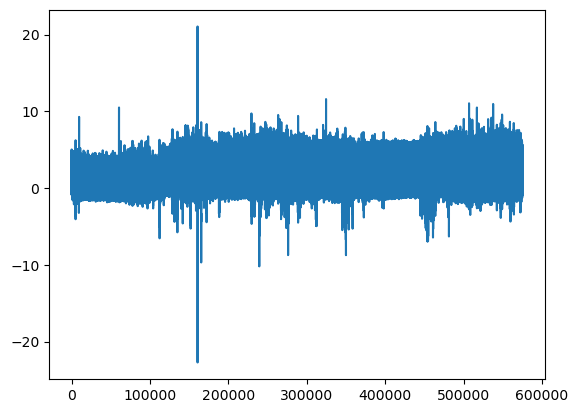

In [73]:
plt.plot(goal_df.iloc[:,0])

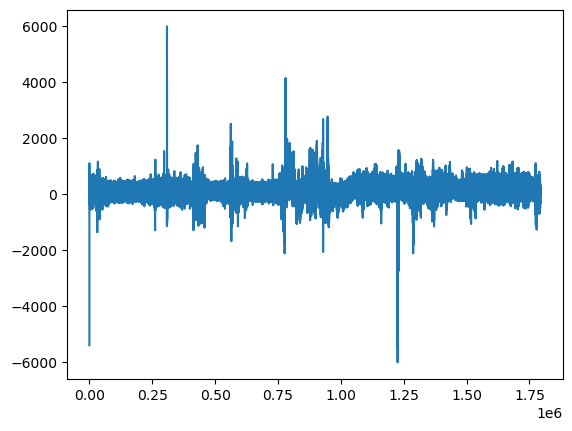

In [7]:
plt.plot(SOT_ecg['EKG'])

# #Visualize the signal with specgram to decide cutoff of signal
# Green is some signal, yellow is strong, blue is none

/Users/jaredperez/opt/miniconda3/envs/tf/lib/python3.10/site-packages/matplotlib/axes/_axes.py:7628: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


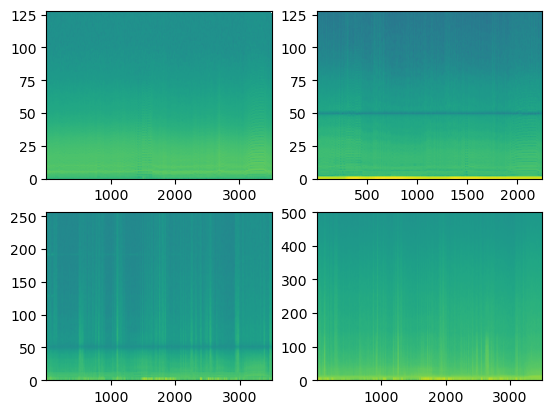

In [91]:
fig,ax=plt.subplots(2,2)
ax[0,0].specgram(reference_sensor['4113:ECG_I'], Fs=256)
ax[0,1].specgram(NEXUS_ecg['Sensor-B:EKG'], Fs=256) #Can see some noise masquearding as signal in this graph
ax[1,0].specgram(SOT_ecg['EKG'], Fs=512)
ax[1,1].specgram(faros_ecg['ECG'], Fs=1000)
plt.ylim()
plt.show()

Looks like under 50 is appropriate for most signals except Faros. Perhaps Faros should get less than 100

# Get Annotations by filtering each signal, standardizing, and then processing each signal to get R_peaks and R_R intervals.

    Plot segment of data to check

In [24]:
#Prepare lists

signals=[reference_sensor, NEXUS, SOT, faros]

reference_ecg=reference_sensor['4113:ECG_I']
NEXUS_ecg=NEXUS['Sensor-B:EKG']
SOT_ecg=SOT['EKG']
faros_ecg=faros['ECG']

ECGs=[reference_ecg, NEXUS_ecg, SOT_ecg, faros_ecg]
srs=[256, 256, 512, 1000]

time_1=reference_sensor['time']
time_2=NEXUS['time']
time_3=SOT['time']
time_4=faros['time']

In [18]:
unitless_signals=[]

for i,x in zip(ECGs, srs):
    b,a =signal.butter(3,(2.5,30), btype='bandpass', fs=x) #Gonna make it easier on myself and pass them all under the
    #same filter
    filtered = signal.filtfilt(b, a, i)
    unitless_signal= (filtered - np.mean(filtered)) / np.std(filtered)
    unitless_signals.append(unitless_signal)
    
    
reference_ecg=unitless_signals[0]
NEXUS_ecg=unitless_signals[1]
SOT_ecg=unitless_signals[2]
faros_ecg=unitless_signals[3]

Process signals using neurokit2 library

In [22]:
annotations=[]
ecg_info=[]

for i,x in zip(unitless_signals, srs):
    ecg_df, info =nk2.ecg_process(i, sampling_rate=x)
    annotation=info['ECG_R_Peaks']
    annotations.append(annotation)
    ecg_info.append(ecg_df)

/Users/jaredperez/opt/miniconda3/envs/tf/lib/python3.10/site-packages/neurokit2/signal/signal_fixpeaks.py:277: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
/Users/jaredperez/opt/miniconda3/envs/tf/lib/python3.10/site-packages/neurokit2/signal/signal_fixpeaks.py:277: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
/Users/jaredperez/opt/miniconda3/envs/tf/lib/python3.10/site-packages/neurokit2/signal/signal_fixpeaks.py:277: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
/Users/jaredperez/opt/miniconda3/envs/tf/lib/python3.10/site-packages/neurokit2/signal/signal_fixpeaks.py:277: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2


 Plot a specifc segment of the signal and the annotations to ensure accurate signal

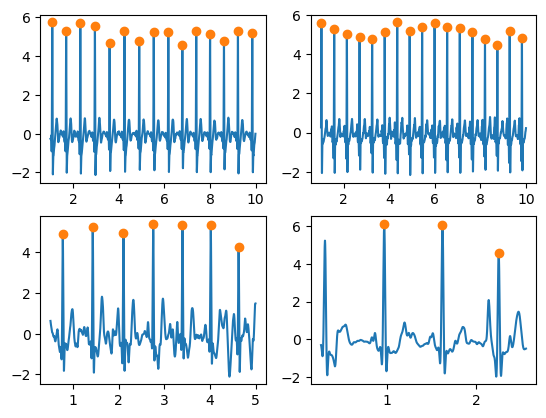

In [26]:
bounded_annotations=[]

for i in annotations:
    annotations_x=i[(i<2560) & (i>=256)] 
    bounded_annotations.append(annotations_x)


fig, ax=plt.subplots(2,2)    
ax[0,0].plot(time_1[256:2560], unitless_signals[0][256:2560])
ax[0,0].plot(time_1[bounded_annotations[0]], unitless_signals[0][bounded_annotations[0]], 'o')
ax[0,1].plot(time_2[256:2560], unitless_signals[1][256:2560])
ax[0,1].plot(time_2[bounded_annotations[1]], unitless_signals[1][bounded_annotations[1]], 'o')
ax[1,0].plot(time_3[256:2560], unitless_signals[2][256:2560])
ax[1,0].plot(time_3[bounded_annotations[2]], unitless_signals[2][bounded_annotations[2]], 'o')
ax[1,1].plot(time_4[256:2560], unitless_signals[3][256:2560])
ax[1,1].plot(time_4[bounded_annotations[3]], unitless_signals[3][bounded_annotations[3]], 'o')
plt.show()

Nice graphs with good signals and annotations throughout

In [29]:
R_R_intervals = []
for i, x in zip(annotations, srs):
    diffs = np.diff(i) / x
    R_R_intervals.append(diffs)
    
reference_rr_intervals=R_R_intervals[0]
NEXUS_rr_intervals=R_R_intervals[1]
SOT_rr_intervals=R_R_intervals[2]
faros_rr_intervals=R_R_intervals[3]

# Remove Inappropriate intervals by filtering through relative R_R interval approach 

    Arrhythmia Classification in Long-Term Data Using Relative RR Intervals (Volmer, 2017)
    
    Relative rr interval is weighted difference and more robust to changes in magnitude than simple percent change. In some contexts if X2 is very large, percent change can be dominated by it. However, relative variability (normalized difference) considered both the difference mand magnitude of the two values. 

Text(0, 0.5, 'RRi(n+1) in %')

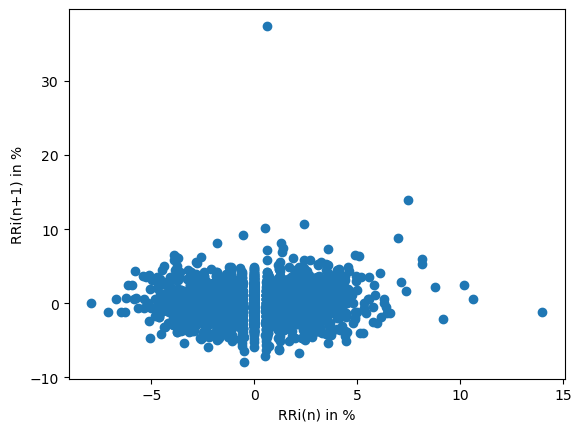

In [69]:
relative_rri=[]
for i in range(1, len(R_R_intervals[0])):
    r_r_i=(R_R_intervals[0][i]-R_R_intervals[0][i-1])/(0.5*(R_R_intervals[0][i]+R_R_intervals[0][i-1]))
    relative_rri.append(r_r_i)
    
relative_rri_reference=np.array(relative_rri)
relative_rri_reference=relative_rri_reference*100 #Decimals need to be converted to percentages

#Visualize the relative rr_interval differences
x = [relative_rri_reference[i] for i in range(len(relative_rri_reference)-1)]
y = [relative_rri_reference[i+1] for i in range(len(relative_rri_reference)-1)]
plt.scatter(x=x, y=y)
plt.xlabel('RRi(n) in %')
plt.ylabel('RRi(n+1) in %')

From this map we cn clearly see some outliers and remove them which likley resulted from some sort of arrythmia or sampling error with the device.

We can confidently say that intervals beyond 10% difference were irregular. And potentially narrow and filter down to 8%.

Text(0, 0.5, 'RRi(n+1) in %')

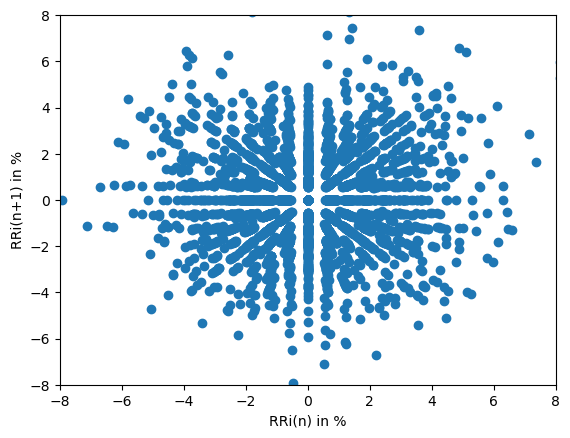

In [72]:
#Visualize the relative rr_interval differences
x = [relative_rri_reference[i] for i in range(len(relative_rri_reference)-1)] #Starts at 0, ends at 5997
y = [relative_rri_reference[i+1] for i in range(len(relative_rri_reference)-1)] #Starts at 1, ends at 5998
plt.scatter(x=x, y=y)
plt.xlim(-8, 8)
plt.ylim(-8,8)
plt.xlabel('RRi(n) in %')
plt.ylabel('RRi(n+1) in %')

Beautiful graph. Let's establish anything outside of 8% relative rr interval change to be an outlier

Find the index of the values that correspond with a change greater than 8%

In [161]:
outlier_indexes=[idx for idx,i in enumerate(relative_rri_reference) if i > 8]
outlier_indexes=np.array(outlier_indexes)+1
reference_rr_intervals=np.delete(reference_rr_intervals, outlier_indexes)

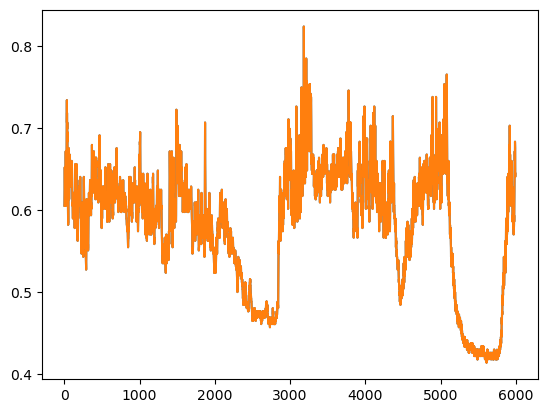

In [214]:
plt.plot(no_outliers)
plt.plot(reference_rr_intervals)

# Repeat for Other Signals

Text(0, 0.5, 'RRi(n+1) in %')

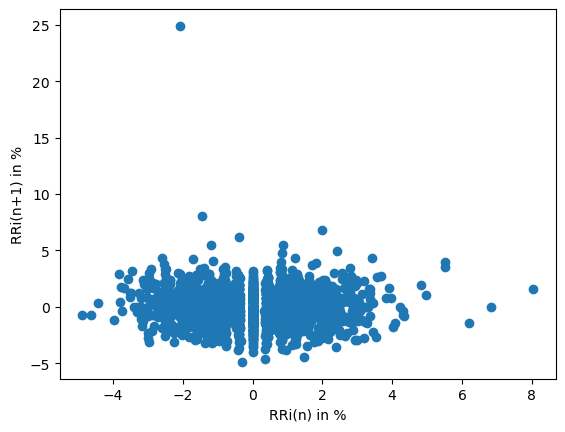

In [163]:
relative_rri_NEXUS=[]
for i in range(1, len(NEXUS_rr_intervals)):
    r_r_i=(NEXUS_rr_intervals[i]-NEXUS_rr_intervals[i-1])/(0.5*NEXUS_rr_intervals[i]+NEXUS_rr_intervals[i-1])
    relative_rri_NEXUS.append(r_r_i)
    
relative_rri_NEXUS=np.array(relative_rri_NEXUS)*100 #Decimals need to be converted to percentages

#Visualize the relative rr_interval differences
x = [relative_rri_NEXUS[i] for i in range(len(relative_rri_NEXUS)-1)]
y = [relative_rri_NEXUS[i+1] for i in range(len(relative_rri_NEXUS)-1)]
plt.scatter(x=x, y=y)
plt.xlabel('RRi(n) in %')
plt.ylabel('RRi(n+1) in %')

5% looks like a reasonable value for this sensor

Lets try a little wider. Maybe 6

Looks like 8 actually works well again

Text(0, 0.5, 'RRi(n+1) in %')

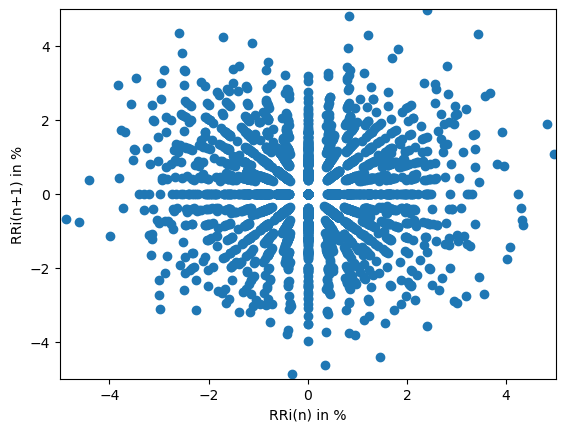

In [182]:
#Visualize the relative rr_interval differences
x = [relative_rri_NEXUS[i] for i in range(len(relative_rri_NEXUS)-1)] #Starts at 0, ends at 5997
y = [relative_rri_NEXUS[i+1] for i in range(len(relative_rri_NEXUS)-1)] #Starts at 1, ends at 5998
plt.scatter(x=x, y=y)
plt.xlim(-5, 5)
plt.ylim(-5,5)
plt.xlabel('RRi(n) in %')
plt.ylabel('RRi(n+1) in %')

In [187]:
outlier_indexes=[idx for idx,i in enumerate(relative_rri_NEXUS) if i > 5]
outlier_indexes=np.array(outlier_indexes)-1
NEXUS_rr_intervals=np.delete(NEXUS_rr_intervals, outlier_indexes)

In [188]:
len(NEXUS_rr_intervals)

3931

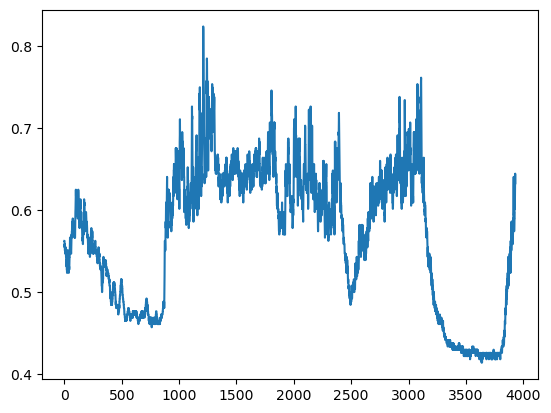

In [189]:
plt.plot(NEXUS_rr_intervals)

# Define Function to expedite process

In [203]:
#Use to plot data, identify outlier threshold

def outlier_identification_removal_relative_rr_interval(rr_intervals, outlier_threshold=None):
    relative_rri=[]
    for i in range(1, len(rr_intervals)):
        r_r_i=(rr_intervals[i]-rr_intervals[i-1])/(0.5*(rr_intervals[i]+rr_intervals[i-1]))
        relative_rri.append(r_r_i)
    
    relative_rri=np.array(relative_rri)
    relative_rri=relative_rri*100 #Decimals need to be converted to percentages

    #Visualize the relative rr_interval differences
    x = [relative_rri[i] for i in range(len(relative_rri)-1)]
    y = [relative_rri[i+1] for i in range(len(relative_rri)-1)]
    plt.scatter(x=x, y=y)
    plt.xlabel('RRi(n) in %')
    plt.ylabel('RRi(n+1) in %')
    
    if outlier_threshold is None:
        cleaned_rr_intervals = rr_intervals
    
    if outlier_threshold is not None:
        x = [relative_rri[i] for i in range(len(relative_rri)-1)]
        y = [relative_rri[i+1] for i in range(len(relative_rri)-1)]
        plt.scatter(x=x, y=y)
        plt.xlim(-outlier_threshold, outlier_threshold)
        plt.ylim(-outlier_threshold,outlier_threshold)
        plt.xlabel('RRi(n) in %')
        plt.ylabel('RRi(n+1) in %')
        
        outlier_indexes=[idx for idx,i in enumerate(relative_rri) if i > outlier_threshold]
        outlier_indexes=np.array(outlier_indexes)+1
        cleaned_rr_intervals=np.delete(rr_intervals, outlier_indexes)
    
    return cleaned_rr_intervals

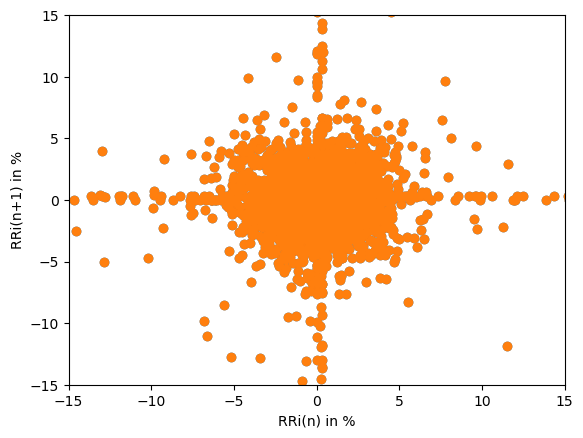

In [225]:
SOT_rr_intervals=outlier_identification_removal_relative_rr_interval(SOT_rr_intervals, 15)

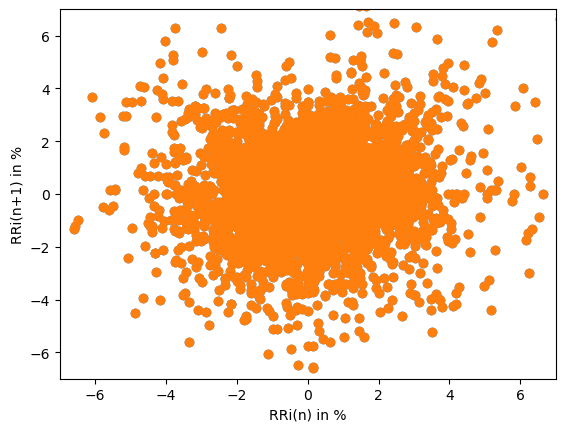

In [229]:
faros_rr_intervals=outlier_identification_removal_relative_rr_interval(faros_rr_intervals, 7)

In [230]:
cleaned_rr_intervals=[reference_rr_intervals, NEXUS_rr_intervals, SOT_rr_intervals, faros_rr_intervals]

# Aligning Signals using short segment of 300 beats from a resting state
    
    Step 1: identify resting state

In [251]:
srs
ecg_info
heart_rates=[]


for i,x in zip(ecg_info, srs):
    heart_rate=i['ECG_Rate'][::x]
    heart_rates.append(heart_rate)
    
lens=[int(len(i)/4) for i in heart_rates]
numbers=[1,2,3,4]

sub_dict=defaultdict(dict)

for i,x,z in zip(heart_rates, lens, numbers):
    sensor=[]
    sensor.append(i[:x].mean())
    sensor.append(i[x:x*2].mean())
    sensor.append(i[x*2:x*3].mean())
    sensor.append(i[x*3:x*4].mean())
    sub_dict[f"Sensor_{z}"]=sensor

/var/folders/wv/c3g7vgxd10n0mdl2_flcjj480000gn/T/ipykernel_1330/2959580811.py:17: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  sensor.append(i[:x].mean())
/var/folders/wv/c3g7vgxd10n0mdl2_flcjj480000gn/T/ipykernel_1330/2959580811.py:18: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  sensor.append(i[x:x*2].mean())
/var/folders/wv/c3g7vgxd10n0mdl2_flcjj480000gn/T/ipykernel_1330/2959580811.py:19: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated.

In [252]:
sub_dict

defaultdict(dict,
            {'Sensor_1': [98.54021311871871,
              107.87609943110569,
              93.32983860900231,
              111.72379534931042],
             'Sensor_2': [112.4890556904029,
              92.10526607797794,
              99.23997941168962,
              116.92584992205693],
             'Sensor_3': [98.44868480374332,
              106.80042175637381,
              93.26215191482818,
              111.41183229867005],
             'Sensor_4': [97.47133141036784,
              107.64137971923007,
              94.39615665780515,
              109.50619496676846]})

Third period of time appears to be closest to resting state

Step 2: Get short segment of 300 beats from the third period

In [254]:
best_alignment_300_beats=[]
for idx,i in enumerate(cleaned_rr_intervals):
    fixed=R_R_intervals[idx][len(cleaned_rr_intervals[idx])//4*2:len(cleaned_rr_intervals[idx])//4*3]
    best_alignment_300_beats.append(fixed)

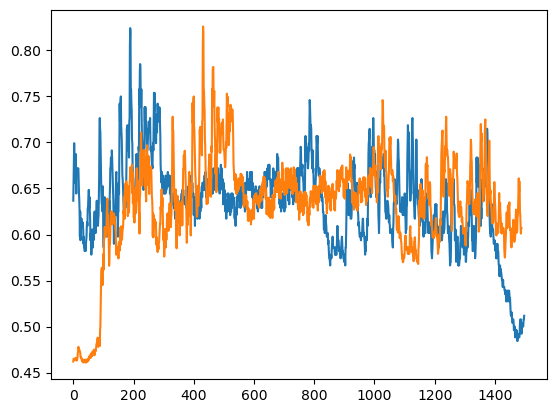

In [259]:
plt.plot(best_alignment_300_beats[0])
plt.plot(best_alignment_300_beats[3])

 Step 3: Align the beats with function that calculates MAE

In [263]:
def multi_sensor_alignment(reference_sensor, sensor_2, manual_shift=None):
    
    #Establish a reference window starting from the index in the middle of the reference signal
    mid_point=len(reference_sensor)//2
    reference_index=[mid_point-150, mid_point+150]
    start=reference_index[0]
    reference_window=range(start, start+300)
    
    #Find the minimum MAE for each possible window of across the sensors
    maes=[]
    window_length=300
    for i in range(1, len(sensor_2)):
        try:
            window=sensor_2[i:i+window_length]
            difference=abs(reference_sensor[reference_window]-window)
            mae=np.mean(difference)
            maes.append(mae)
        except:
            pass
    index=np.argmin(maes)
    
    #Establish Shift
    shift=(reference_window[0]-index)
    if manual_shift==None:
        pass
    if manual_shift!=None:
        shift=manual_shift
    
    #Develop Dataframe from Data and shift data accordingly
    df=pd.DataFrame(data=[reference_sensor, sensor_2]).T
    df[1]=df[1].shift(shift)
    
    aligned_signals=df
    
    
    #plot shifted data and OG data to see comparison
    fig,ax=plt.subplots(1,2)
    ax[0].plot(reference_sensor)
    ax[0].plot(sensor_2)
    ax[1].plot(df)
    plt.show()
    
    return aligned_signals, shift

 Though the paper aligns it with 300 beats I will just go ahead and align it with the whole cleaned RR_interval

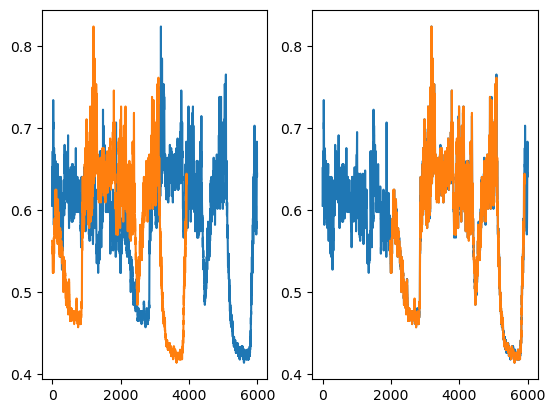

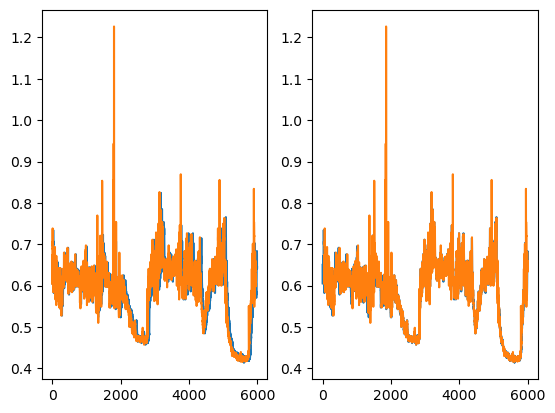

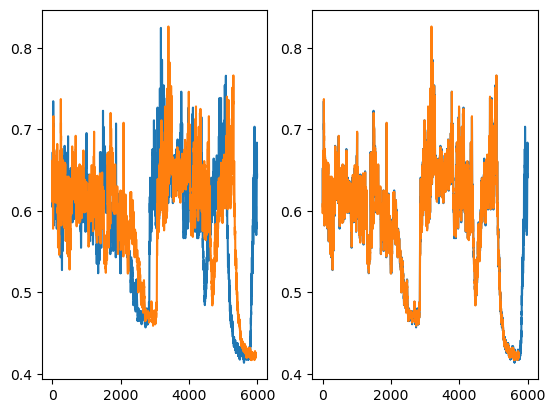

In [271]:
aigned_signals_ref_NEXUS, NEXUS_shift=multi_sensor_alignment(cleaned_rr_intervals[0], cleaned_rr_intervals[1])
aigned_signals_ref_SOT, SOT_shift=multi_sensor_alignment(cleaned_rr_intervals[0], cleaned_rr_intervals[2])
aigned_signals_ref_faros, faros_shift=multi_sensor_alignment(cleaned_rr_intervals[0], cleaned_rr_intervals[3])

In [279]:
shifts=[NEXUS_shift, SOT_shift, faros_shift]

In [280]:
shifts

[1971, 45, -219]

In [283]:
aigned_signals_ref_NEXUS=aigned_signals_ref_NEXUS.rename(columns={0: 'Reference RR Intervals',
                               1: 'Nexus RR Intervals'})
aigned_signals_ref_SOT=aigned_signals_ref_SOT.rename(columns={1: 'SOT RR Intervals'})
aigned_signals_ref_faros=aigned_signals_ref_faros.rename(columns={1: 'faros RR Intervals'})

aigned_signals_ref_faros=aigned_signals_ref_faros.drop(columns=0)
aigned_signals_ref_SOT=aigned_signals_ref_SOT.drop(columns=0)

aligned_signals=pd.concat([aigned_signals_ref_NEXUS, aigned_signals_ref_SOT, aigned_signals_ref_faros], axis=1)

In [290]:
aligned_signals

,Reference RR Intervals,Nexus RR Intervals,SOT RR Intervals,faros RR Intervals
0,0.605469,NaN,NaN,0.608
1,0.609375,NaN,NaN,0.605
2,0.621094,NaN,NaN,0.597
3,0.640625,NaN,NaN,0.605
4,0.644531,NaN,NaN,0.610
...,...,...,...,...
5987,0.683594,NaN,0.640625,NaN
5988,0.679688,NaN,0.660156,NaN
5989,0.675781,NaN,0.654297,NaN
5990,0.640625,NaN,0.638672,NaN


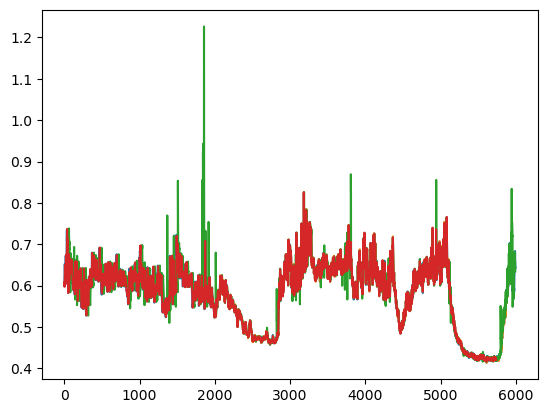

In [291]:
plt.plot(aligned_signals)

Some nicely aligned data

# Linear Resampling of Data

    Inaccuracy of given sampling rates can lead to linear drifts in differences in aligned heart beats
    
    Calculate pairwise differences in each signal and plot

In [293]:
aligned_signals['NEXUS continuous_difference']=aligned_signals['Nexus RR Intervals'].diff()
aligned_signals['SOT continuous_difference']=aligned_signals['SOT RR Intervals'].diff()
aligned_signals['faros continuous_difference']=aligned_signals['faros RR Intervals'].diff()

In [294]:
aligned_signals

,Reference RR Intervals,Nexus RR Intervals,SOT RR Intervals,faros RR Intervals,NEXUS continuous_difference,SOT continuous_difference,faros continuous_difference
0,0.605469,NaN,NaN,0.608,NaN,NaN,NaN
1,0.609375,NaN,NaN,0.605,NaN,NaN,-0.003
2,0.621094,NaN,NaN,0.597,NaN,NaN,-0.008
3,0.640625,NaN,NaN,0.605,NaN,NaN,0.008
4,0.644531,NaN,NaN,0.610,NaN,NaN,0.005
...,...,...,...,...,...,...,...
5987,0.683594,NaN,0.640625,NaN,NaN,0.003906,NaN
5988,0.679688,NaN,0.660156,NaN,NaN,0.019531,NaN
5989,0.675781,NaN,0.654297,NaN,NaN,-0.005859,NaN
5990,0.640625,NaN,0.638672,NaN,NaN,-0.015625,NaN


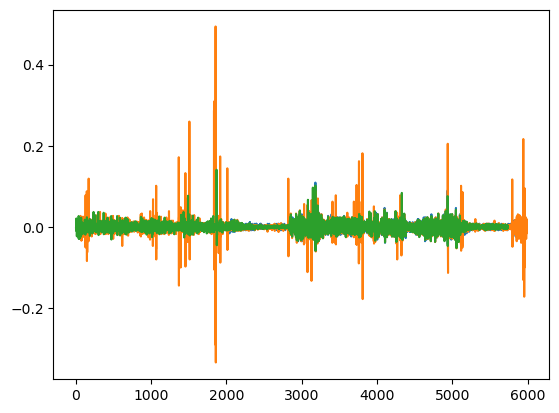

In [297]:
plt.plot(aligned_signals['NEXUS continuous_difference'])
plt.plot(aligned_signals['SOT continuous_difference'])
plt.plot(aligned_signals['faros continuous_difference'])

 Check and correct for linear drifts of sampling freqeuncy due to hardware error
 
 Robust Linear regression for correction of linear drifts of sampling freqeuncy
 
 Using statsmodel library and HuberT 

In [498]:
aligned_signals

,Reference RR Intervals,Nexus RR Intervals,SOT RR Intervals,faros RR Intervals,NEXUS continuous_difference,SOT continuous_difference,faros continuous_difference,time,HEXOSKIN continuous_difference
0,0.605469,NaN,NaN,0.608,NaN,NaN,NaN,0.472656,NaN
1,0.609375,NaN,NaN,0.605,NaN,NaN,-0.003,1.078125,0.003906
2,0.621094,NaN,NaN,0.597,NaN,NaN,-0.008,1.687500,0.011719
3,0.640625,NaN,NaN,0.605,NaN,NaN,0.008,2.308594,0.019531
4,0.644531,NaN,NaN,0.610,NaN,NaN,0.005,2.949219,0.003906
...,...,...,...,...,...,...,...,...,...
5987,0.683594,NaN,0.640625,NaN,NaN,0.003906,NaN,3491.835938,0.023438
5988,0.679688,NaN,0.660156,NaN,NaN,0.019531,NaN,3492.457031,-0.003906
5989,0.675781,NaN,0.654297,NaN,NaN,-0.005859,NaN,3493.097656,-0.003906
5990,0.640625,NaN,0.638672,NaN,NaN,-0.015625,NaN,3493.746094,-0.035156


In [630]:
y=aligned_signals['SOT continuous_difference'].dropna().reset_index(drop=True)
x=reference_time[:len(y)]

x = sm.add_constant(x)


model = sm.RLM(y,x, M=sm.robust.norms.HuberT())
results = model.fit()

slope=results.params[0]
intercept=results.params[1]

#Use slope of line to develop adjustment factor...fs_hat=fs*(1-slops)
fs=512
adjustment_factor=fs*(1-slope)

print(results.params)
print(f"Adjustment Factor is: {adjustment_factor}")

const   -6.309735e-04
time     2.228310e-07
dtype: float64
Adjustment Factor is: 512.3230584441985


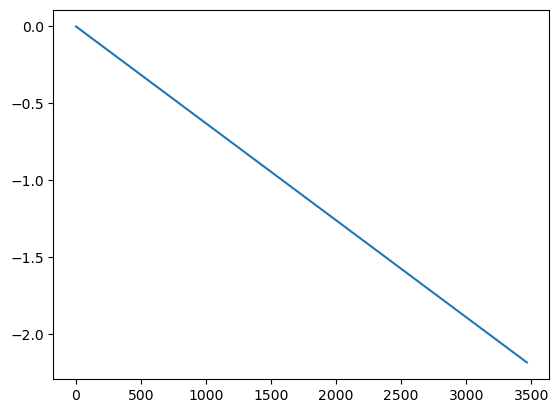

In [631]:
line=slope*x.iloc[:,1]+intercept #Can see a linear drift as time goes on
plt.plot(x['time'], line)

Define a function to apply to all the continuous differences and assess the linear drifts graphically and the adjustment factors

In [475]:
def linear_resampling(x_reference_time, y_continuous_differece, signal_fs):
    y=y_continuous_differece.dropna().reset_index(drop=True)
    x=x_reference_time[:len(y)]
    x = sm.add_constant(x)
    
    model = sm.RLM(y,x, M=sm.robust.norms.HuberT())
    results = model.fit()
    
    slope=results.params[0]
    intercept=results.params[1]

    fs=signal_fs
    adjustment_factor=fs*(1-slope)

    print(f"Slope: {slope}, intercept: {intercept}")
    print(f"Adjustment Factor is: {adjustment_factor}")
    
    line=slope*x.iloc[:,1]+intercept #Can see a positive linear drift
    plt.plot(x['time'], line)
    
    return adjustment_factor

Slope: -0.0004935473283480675, intercept: 1.4453641140123405e-07
Adjustment Factor is: 256.1263481160571


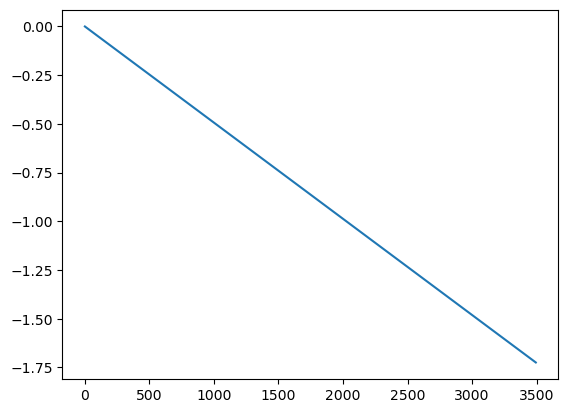

In [499]:
new_fs_HEX=linear_resampling(time, aligned_signals['HEXOSKIN continuous_difference'], 256)

In [500]:
subject_1_adjusted_fs=[new_fs_HEX, new_fs_NEXUS, new_fs_SOT, new_fs_SOT]

print(f"HEXOSKIN (reference) Linearly Adjusted Sampling Rate is: {new_fs_HEX}")
print(f"NEXUS Linearly Adjusted Sampling Rate is: {new_fs_NEXUS}")
print(f"SOT Linearly Adjusted Sampling Rate is: {new_fs_SOT}")
print(f"Faros Linearly Adjusted Sampling Rate is: {new_fs_faros}")

HEXOSKIN (reference) Linearly Adjusted Sampling Rate is: 256.1263481160571
NEXUS Linearly Adjusted Sampling Rate is: 256.0933789523902
SOT Linearly Adjusted Sampling Rate is: 512.3230584441985
Faros Linearly Adjusted Sampling Rate is: 1000.5033247968131


Resample Data with the linear resampling rate

In [503]:
adjusted_ecgs=[]
for ecg,fs in zip(unitless_signals, subject_1_adjusted_fs):
    adjusted_signal=nk2.signal_resample(ecg, desired_length=len(ecg), desired_sampling_rate=fs)
    adjusted_ecgs.append(adjusted_signal)

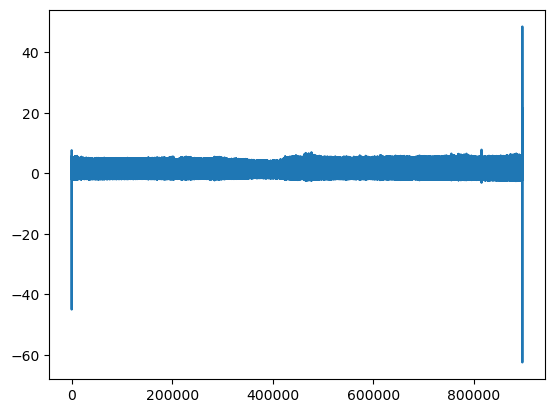

In [515]:
plt.plot(adjusted_ecgs[0]) #Hexoskin

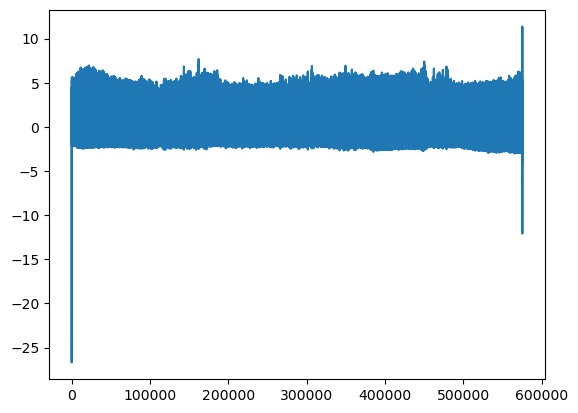

In [516]:
plt.plot(adjusted_ecgs[1]) #Nexus

# Step 4 Non-Linear Resampling of Data

    Fit a robust Quadratic Regression to the Data to find local changes in sampling freqeuncy
    
    In the paper they linearly resample and then again apply time shift d, for the sake of brevity and also because the sample rates for this subject don't seem to shift much. We will skip doing that and go straight into the non-linear resampling.
    
    The paper is also generally not clear if the linear resampling was done for every sensor oor only for the "second" sensor which they say, but what is "second" sensor? That also is unclear. For future subjects where the Fs of Nexus was inappropriatley stored, I will analyze and see if I can make sense of when they applied linear resampling

In [744]:
aligned_signals

,Reference RR Intervals,Nexus RR Intervals,SOT RR Intervals,faros RR Intervals,NEXUS continuous_difference,SOT continuous_difference,faros continuous_difference,time,HEXOSKIN continuous_difference
0,0.605469,NaN,NaN,0.608,NaN,NaN,NaN,0.472656,NaN
1,0.609375,NaN,NaN,0.605,NaN,NaN,-0.003,1.078125,0.003906
2,0.621094,NaN,NaN,0.597,NaN,NaN,-0.008,1.687500,0.011719
3,0.640625,NaN,NaN,0.605,NaN,NaN,0.008,2.308594,0.019531
4,0.644531,NaN,NaN,0.610,NaN,NaN,0.005,2.949219,0.003906
...,...,...,...,...,...,...,...,...,...
5987,0.683594,NaN,0.640625,NaN,NaN,0.003906,NaN,3491.835938,0.023438
5988,0.679688,NaN,0.660156,NaN,NaN,0.019531,NaN,3492.457031,-0.003906
5989,0.675781,NaN,0.654297,NaN,NaN,-0.005859,NaN,3493.097656,-0.003906
5990,0.640625,NaN,0.638672,NaN,NaN,-0.015625,NaN,3493.746094,-0.035156


 Lets fit it for Hexoskin to SOT first since SOT is close

In [745]:
test=aligned_signals['SOT continuous_difference']

In [749]:
test

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
5987    0.003906
5988    0.019531
5989   -0.005859
5990   -0.015625
5991   -0.003906
Name: SOT continuous_difference, Length: 5992, dtype: float64

In [750]:
#Create polynomial feature transformer and fit to data
poly_features = PolynomialFeatures(degree=3)

y=aligned_signals['SOT continuous_difference'].dropna()
X_poly = poly_features.fit_transform(aligned_signals['HEXOSKIN continuous_difference'][y.index].to_numpy().reshape(-1,1)) #Fit to reference signal

ransac = RANSACRegressor(random_state=0)
ransac.fit(X_poly, y)
y_pred = ransac.predict(X_poly)

inlier_reg = ransac.estimator_
intercept = inlier_reg.intercept_
coefficients = inlier_reg.coef_

residuals=y_pred-y

In [766]:
window_size=100 #Smoothing function to the predictions 
polyorder = 3
smoothed = signal.savgol_filter(y_pred, window_size, polyorder)

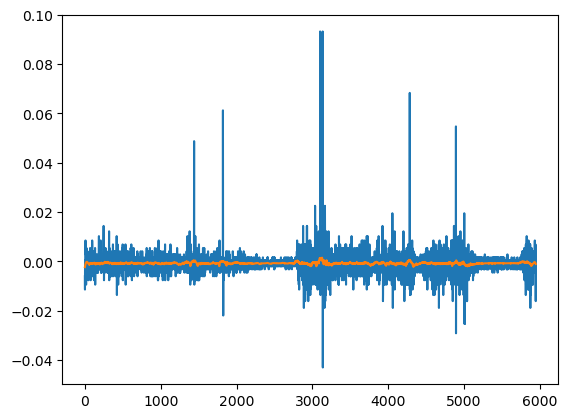

In [767]:
plt.plot(y_pred)
plt.plot(smoothed)

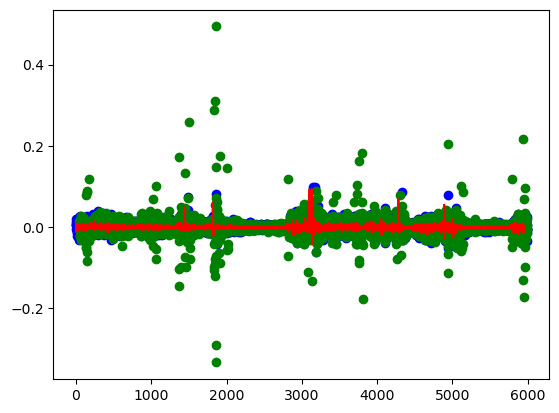

In [756]:
plt.scatter(x=aligned_signals.index, y=aligned_signals['HEXOSKIN continuous_difference'], color='blue')
plt.scatter(x=aligned_signals.index, y=aligned_signals['SOT continuous_difference'], color='green')
plt.plot(y_pred, color='red')

In [777]:
SOT_smoothed=pd.Series(smoothed)

 Sensor and subject based corrective value that I will apply to time to linearly interpolate in future step

In [769]:
#Define Function to fit Robust Quadratic Regression from X data (reference) to y data (target sensor):

def robust_quadratic_regression(reference_sensor, target_sensor, polynomial_degree):
    poly_features = PolynomialFeatures(degree=polynomial_degree)

    y=target_sensor.dropna()
    X_poly = poly_features.fit_transform(reference_sensor[y.index].to_numpy().reshape(-1,1)) 

    ransac = RANSACRegressor(random_state=0)
    ransac.fit(X_poly, y)
    y_pred = ransac.predict(X_poly)

    inlier_reg = ransac.estimator_
    intercept = inlier_reg.intercept_
    coefficients = inlier_reg.coef_
    
    window_size=100 #Smoothing function to the predictions 
    polyorder = polynomial_degree
    smoothed_signal = signal.savgol_filter(y_pred, window_size, polyorder)
    
    plt.plot(y_pred)
    plt.plot(smoothed_signal)
    
    return y_pred, smoothed_signal

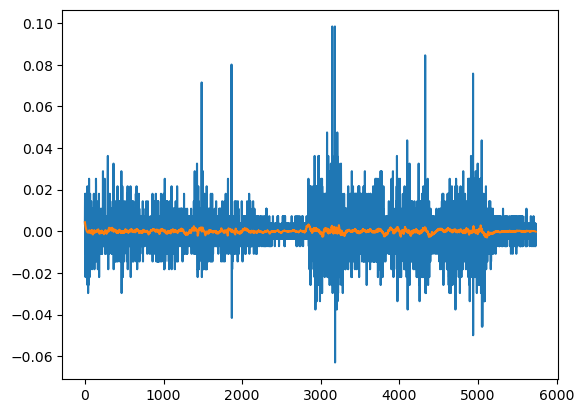

In [775]:
predictions_faros, faros_smoothed=robust_quadratic_regression(aligned_signals['HEXOSKIN continuous_difference'], 
                            aligned_signals['faros continuous_difference'], polynomial_degree=3)

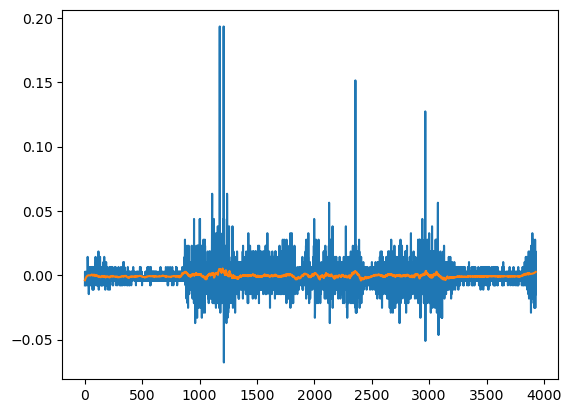

In [787]:
predictions_NEXUS, NEXUS_smoothed=robust_quadratic_regression(aligned_signals['HEXOSKIN continuous_difference'],
                           aligned_signals['NEXUS continuous_difference'], polynomial_degree=3)

In [788]:
NEXUS_smoothed=pd.Series(NEXUS_smoothed)
faros_smoothed=pd.Series(faros_smoothed)

 Now use the fitted beat misplacements to derive sensor specific time adjustments

In [801]:
time_corrections=pd.DataFrame([time, NEXUS_smoothed, SOT_smoothed, faros_smoothed])
time_corrections=time_corrections.T
time_corrections=time_corrections.rename(columns={'Unnamed 0': 'NEXUS smoothed',
                                                'Unnamed 1': 'SOT_smoothed',
                                                'Unnamed 2': 'faros_smoothed'})
time_corrections=time_corrections.rename(columns={'time': 'reference time'})
time_corrections=time_corrections[time_corrections['time']<3357] #Not doing dropna() because i would lose lots of
                                                                    #values because of NEXUS


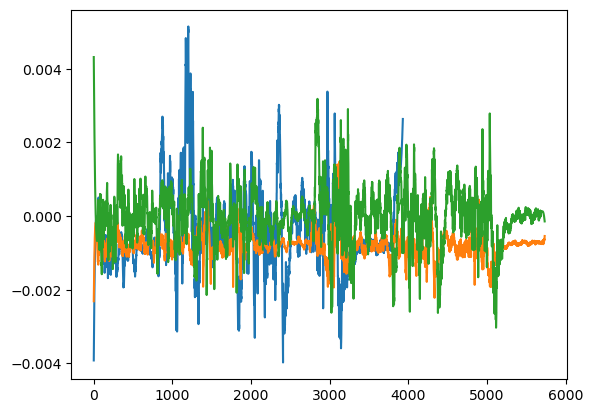

In [818]:
plt.plot(time_corrections.iloc[:,1:]) #Plot of the changes in local sampling freqeuncy

In [858]:
time_corrections

,reference time,NEXUS smoothed,SOT_smoothed,faros_smoothed
0,0.472656,-0.003918,-0.002311,0.004318
1,1.078125,-0.003650,-0.002120,0.004043
2,1.687500,-0.003394,-0.001939,0.003778
3,2.308594,-0.003149,-0.001769,0.003522
4,2.949219,-0.002916,-0.001609,0.003276
...,...,...,...,...
5728,3355.023438,NaN,-0.000654,-0.000065
5729,3355.449219,NaN,-0.000629,-0.000083
5730,3355.875000,NaN,-0.000621,-0.000102
5731,3356.292969,NaN,-0.000558,-0.000122


 Quick misstep when I realized that the only time column I have is the reference time, I need to apply the time adjustments of the fitted beat misplacements (smoothed columns) to the time columns for each sensor as to "shift" the time appropriatley to the reference time
 
 So i need to backtrack quickly and add the time columns for each sensor

In [873]:
#rr_times is just ecg_info but with only the three target sensors
rr_times=[i[i['ECG_R_Peaks']==1] for i in rr_times]
rr_times=[i.reset_index(drop=True) for i in rr_times]

In [876]:
time_corrections['NEXUS time']=rr_times[0]['NEXUS time']
time_corrections['SOT time']=rr_times[1]['SOT time']
time_corrections['faros time']=rr_times[2]['faros time']

In [879]:
time_corrections['NEXUS_corrected_time']=time_corrections['NEXUS time']+time_corrections['NEXUS smoothed']
time_corrections['SOT_corrected_time']=time_corrections['SOT time']+time_corrections['SOT_smoothed']
time_corrections['faros_corrected_time']=time_corrections['faros time']+time_corrections['faros_smoothed']

In [880]:
time_corrections

,reference time,NEXUS smoothed,SOT_smoothed,faros_smoothed,NEXUS time,SOT time,faros time,NEXUS_corrected_time,SOT_corrected_time,faros_corrected_time
0,0.472656,-0.003918,-0.002311,0.004318,0.453125,0.769531,0.966,0.449207,0.767220,0.970318
1,1.078125,-0.003650,-0.002120,0.004043,1.015625,1.427734,1.621,1.011975,1.425615,1.625043
2,1.687500,-0.003394,-0.001939,0.003778,1.578125,2.101562,2.252,1.574731,2.099623,2.255778
3,2.308594,-0.003149,-0.001769,0.003522,2.132812,2.753906,2.877,2.129663,2.752137,2.880522
4,2.949219,-0.002916,-0.001609,0.003276,2.691406,3.396484,3.490,2.688490,3.394875,3.493276
...,...,...,...,...,...,...,...,...,...,...
5728,3355.023438,NaN,-0.000654,-0.000065,NaN,3360.029297,3400.105,NaN,3360.028643,3400.104935
5729,3355.449219,NaN,-0.000629,-0.000083,NaN,3360.453125,3400.530,NaN,3360.452496,3400.529917
5730,3355.875000,NaN,-0.000621,-0.000102,NaN,3360.878906,3400.954,NaN,3360.878286,3400.953898
5731,3356.292969,NaN,-0.000558,-0.000122,NaN,3361.302734,3401.380,NaN,3361.302176,3401.379878


In [882]:
correct_times=time_corrections[['NEXUS_corrected_time', 'SOT_corrected_time', 'faros_corrected_time']]

In [883]:
correct_times

,NEXUS_corrected_time,SOT_corrected_time,faros_corrected_time
0,0.449207,0.767220,0.970318
1,1.011975,1.425615,1.625043
2,1.574731,2.099623,2.255778
3,2.129663,2.752137,2.880522
4,2.688490,3.394875,3.493276
...,...,...,...
5728,NaN,3360.028643,3400.104935
5729,NaN,3360.452496,3400.529917
5730,NaN,3360.878286,3400.953898
5731,NaN,3361.302176,3401.379878


# Final Step: Linear Interpolation of corrected times

In [886]:
aligned_signals['Reference RR Intervals']

0       0.605469
1       0.609375
2       0.621094
3       0.640625
4       0.644531
          ...   
5987    0.683594
5988    0.679688
5989    0.675781
5990    0.640625
5991    0.644531
Name: Reference RR Intervals, Length: 5992, dtype: float64

In [1216]:
ECG_t=SOT['time']

ref_Ann = aligned_signals['Reference RR Intervals'][:len(dff)] #R_peaks for reference annotations
dff = time_corrections['SOT_smoothed'] #Delay of the second signal (SOT Smooth)


f = interp1d(ref_Ann, dff, kind='linear', fill_value='extrapolate')
vq = f(ECG_t) #ECG_t is the time of the originral sensor

/Users/jaredperez/opt/miniconda3/envs/tf/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/jaredperez/opt/miniconda3/envs/tf/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


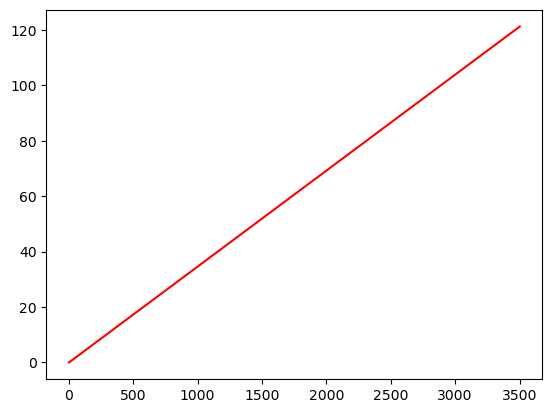

In [1217]:
plt.plot(ECG_t, vq, 'r')

In [1218]:
target_ecg=unitless_signals[2]
f_x=interp1d(ECG_t-vq, target_ecg, kind='linear', fill_value='extraploate')

In [1219]:
t=reference_sensor['time']
ECG_correct=f_x(t)

In [1220]:
ECG_correct

array([1.47562569, 1.47562569, 1.47562569, ...,        nan,        nan,
              nan])

In [1224]:
SOT_correct=pd.Series(ECG_correct)

In [1228]:
SOT_correct=SOT_correct.dropna()

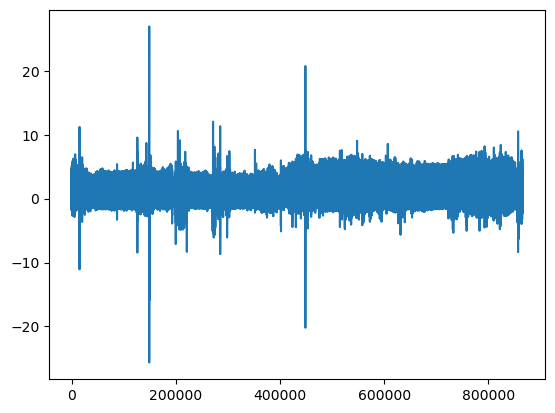

In [1229]:
plt.plot(SOT_correct)

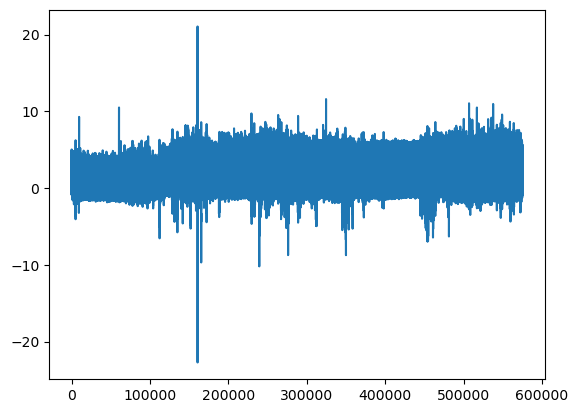

In [1230]:
plt.plot(desired_result['SOT/EKG_filtered'])

# Faros

In [1028]:
linear_interpoloate_ECG(time_corrections['faros_smoothed'],aligned_signals['Reference RR Intervals'],
                       reference_sensor['time'], faros['time'], unitless_signals[3])

array([-0.14904133, -0.14904133, -0.14904133, ..., -0.10486311,
       -0.10706979, -0.10927647])

In [1203]:
ECG_t=faros['time']

ref_Ann = aligned_signals['Reference RR Intervals'][:len(dff)] #R_peaks for reference annotations
dff = time_corrections['faros_smoothed'] #Delay of the second signal (SOT Smooth)


f = interp1d(ref_Ann, dff, kind='linear', fill_value='extrapolate')
vq = f(ECG_t) #ECG_t is the time of the originral sensor

/Users/jaredperez/opt/miniconda3/envs/tf/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


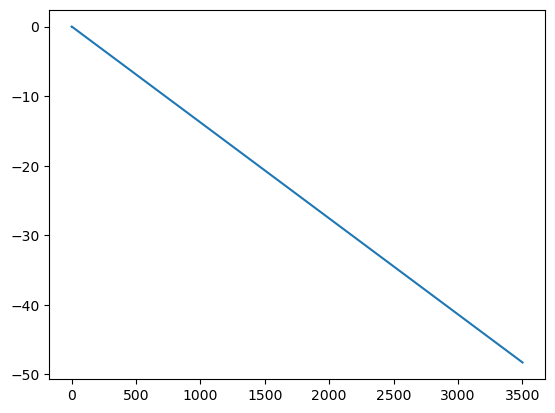

In [1204]:
plt.plot(ECG_t, vq)

In [1205]:
target_ecg=unitless_signals[3]
f_x=interp1d(ECG_t-vq, target_ecg, kind='linear', fill_value='extraploate')

In [1207]:
t=reference_sensor['time']
ECG_corrected=f_x(t)

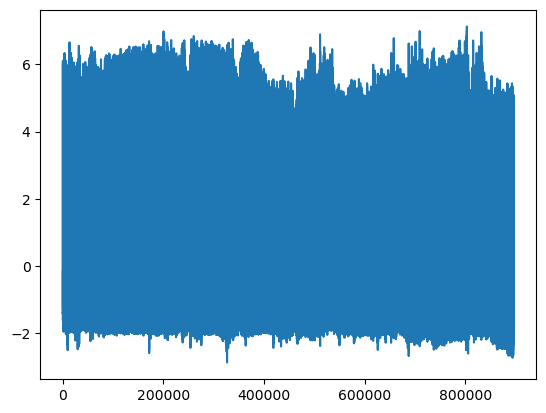

In [1208]:
faros_corrected=ECG_corrected
plt.plot(ECG_corrected)

# NEXUS

In [1178]:
ECG_t=NEXUS['time']

ref_Ann = aligned_signals['Reference RR Intervals'][:len(dff)] #R_peaks for reference annotations
dff = time_corrections['NEXUS smoothed'] #Delay of the second signal (SOT Smooth)


f = interp1d(ref_Ann, dff, kind='linear', fill_value='extrapolate')
vq = f(ECG_t) #ECG_t is the time of the originral sensor

In [1069]:
NEXUS_time=pd.Series(ECG_t-vq)[:len(target_ecg)]

In [1074]:
NEXUS_time[:200]=reference_time[:200] #Filling NaN Value

In [1179]:
target_ecg=unitless_signals[1]
f_x=interp1d(ECG_t-vq, target_ecg, kind='linear', fill_value='extrapolate')

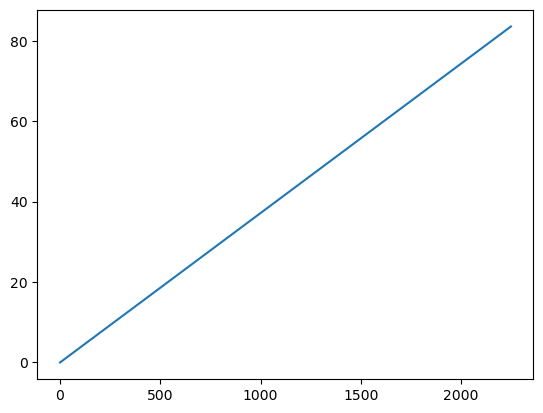

In [1180]:
plt.plot(ECG_t,vq)

In [1183]:
t=reference_sensor['time']
NEXUS_corrected=f_x(t)

NEXUS_corrected

array([0.04413513, 0.04379205, 0.04344896, ...,        nan,        nan,
              nan])

In [1189]:
NEXUS_corrected=pd.Series(NEXUS_corrected).dropna()

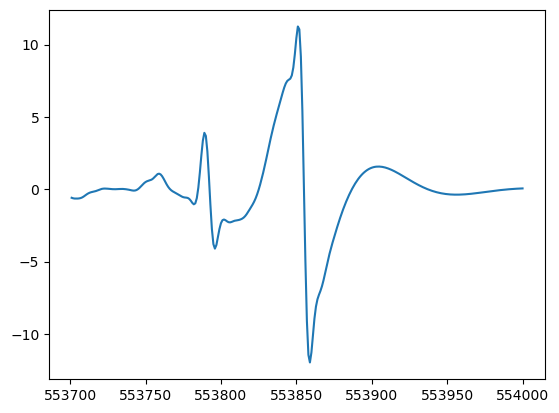

In [1196]:
argmax=553851

plt.plot(NEXUS_corrected[argmax-150:argmax+150])

In [1199]:
NEXUS_corrected=NEXUS_corrected[:argmax-150]

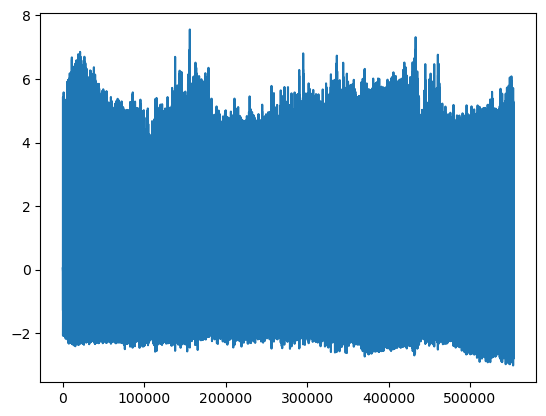

In [1200]:
plt.plot(NEXUS_corrected) #Outlier eliminated

Function never really worked because the lengths of the signals were different. Function may work in future subjects if data isn't missing for any signals but because of missing data it was not possible to define a function

# With the New ECG and Time Series Data. Resample all of them to 256Hz

In [1125]:
signals

[               time   4113:ECG_I
 0          0.000000  1900.842412
 1          0.003906 -8697.550007
 2          0.007812 -8703.950002
 3          0.011719 -8703.950002
 4          0.015625 -8703.950002
 ...             ...          ...
 896507  3501.980469 -8703.950002
 896508  3501.984375 -8703.950002
 896509  3501.988281 -8703.950002
 896510  3501.992188 -8703.950002
 896511  3501.996094 -8703.950002
 
 [896512 rows x 2 columns],
                time  [B] HRV Amp.  Sensor-B:EKG
 0          0.000000     28.573273   -375.727628
 1          0.003906     28.573273  -1486.523036
 2          0.007812     28.573273  -4039.355384
 3          0.011719     28.573273  -5269.976212
 4          0.015625     28.573273  -5772.347725
 ...             ...           ...           ...
 575483  2247.980469     49.498221 -11283.628352
 575484  2247.984375     49.498221 -11283.628352
 575485  2247.988281     49.498221 -11283.628352
 575486  2247.992188     49.498221 -11283.628352
 575487  2247.996094   

In [1231]:
len(NEXUS_corrected)

553701

In [1233]:
corrected_ECGs=[NEXUS_corrected, SOT_correct, faros_corrected]

In [1247]:
test=[nk2.signal_resample(i, desired_length=len(desired_result), desired_sampling_rate=256) for i in corrected_ECGs]

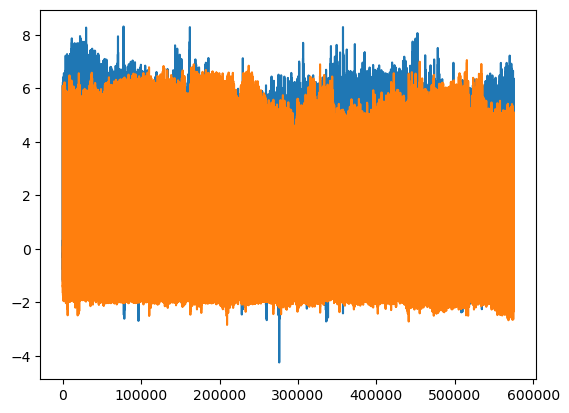

In [1250]:
plt.plot(desired_result['FAROS/ECG_filtered'])
plt.plot(test[2])

In [1260]:
my_result=pd.DataFrame(test).T
my_result=my_result.rename(columns={0: 'NEXUS_filtered',
                                   1: 'SOT_filtered',
                                   2: 'faros_filtered'})

In [1286]:
my_HEX=unitless_signals[0][309000:-500]

In [1288]:
my_HEX=nk2.signal_resample(my_HEX, desired_length=len(my_result), desired_sampling_rate=256)

Manually played around with aligning the HEXOSKIN close to the outcome in goal_df and then resampled

In [1289]:
my_result['HEXOSKIN']=my_HEX

In [1294]:
my_result

,NEXUS_filtered,SOT_filtered,faros_filtered,HEXOSKIN
0,0.044135,1.475626,-1.402508,-0.045794
1,0.043808,1.475626,-1.402508,-0.046822
2,0.043472,1.475626,-1.402508,-0.045251
3,0.043145,1.475626,-1.402508,-0.040584
4,0.042814,1.475626,-1.402508,-0.034852
...,...,...,...,...
575099,-0.233573,-0.043873,0.580627,-0.098594
575100,-0.314302,-0.257171,0.701727,-0.140495
575101,-0.390166,-0.318397,0.617582,-0.181035
575102,-0.464233,-0.224262,0.322762,-0.212637


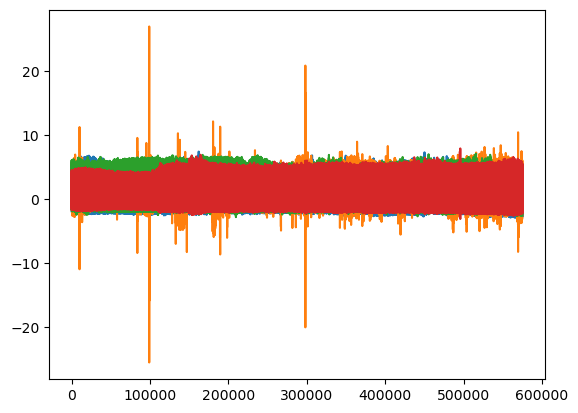

In [1292]:
plt.plot(my_result)

In [1295]:
goal_df

,SOT/EKG_filtered,FAROS/ECG_filtered,NEXUS/Sensor-B:EEG_filtered,HEXOSKIN/ECG_I_filtered
0,-0.315972,-0.185457,-0.156465,-0.241570
1,-0.420182,-0.276845,-0.052867,-0.195505
2,-0.415506,-0.283934,-0.044679,-0.125561
3,-0.378097,-0.315546,-0.235676,-0.240799
4,-0.456255,-0.321293,-0.480787,-0.171625
...,...,...,...,...
575099,-0.382105,-0.144649,-0.109472,0.026037
575100,-0.345364,-0.197527,-0.170705,0.056079
575101,-0.380769,-0.199252,-0.248849,0.025112
575102,-0.321984,-0.336237,-0.252409,0.139426


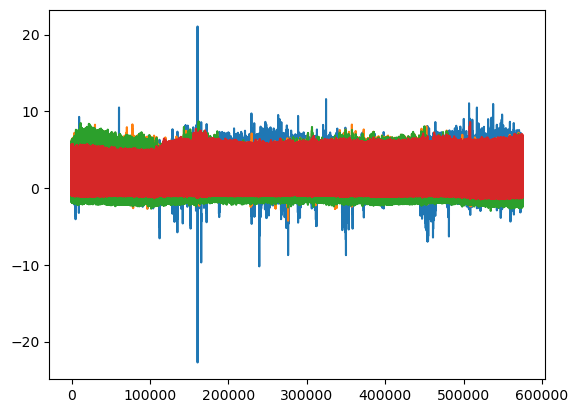

In [1293]:
plt.plot(goal_df)

In [1302]:
my_descriptive_stats=[my_result.mean(), my_result.median(), my_result.std(), my_result.max(), my_result.min()]

In [1303]:
my_descriptive_stats

[NEXUS_filtered    0.000506
 SOT_filtered     -0.000359
 faros_filtered   -0.000156
 HEXOSKIN          0.000543
 dtype: float64,
 NEXUS_filtered   -0.184656
 SOT_filtered     -0.160177
 faros_filtered   -0.140309
 HEXOSKIN         -0.101123
 dtype: float64,
 NEXUS_filtered    0.981249
 SOT_filtered      0.985104
 faros_filtered    0.996933
 HEXOSKIN          0.974095
 dtype: float64,
 NEXUS_filtered     7.412786
 SOT_filtered      26.975736
 faros_filtered     7.054613
 HEXOSKIN           7.904295
 dtype: float64,
 NEXUS_filtered    -2.978788
 SOT_filtered     -25.569411
 faros_filtered    -2.841611
 HEXOSKIN          -3.127718
 dtype: float64]

In [1304]:
goal_stats=[goal_df.mean(), goal_df.median(), goal_df.std(), goal_df.max(), goal_df.min()]

In [1305]:
goal_stats

[SOT/EKG_filtered               0.028031
 FAROS/ECG_filtered             0.012136
 NEXUS/Sensor-B:EEG_filtered   -0.000196
 HEXOSKIN/ECG_I_filtered       -0.002895
 dtype: float64,
 SOT/EKG_filtered              -0.245830
 FAROS/ECG_filtered            -0.222817
 NEXUS/Sensor-B:EEG_filtered   -0.237812
 HEXOSKIN/ECG_I_filtered       -0.183180
 dtype: float64,
 SOT/EKG_filtered               1.036985
 FAROS/ECG_filtered             0.959818
 NEXUS/Sensor-B:EEG_filtered    0.990727
 HEXOSKIN/ECG_I_filtered        0.929077
 dtype: float64,
 SOT/EKG_filtered               21.065884
 FAROS/ECG_filtered              8.310712
 NEXUS/Sensor-B:EEG_filtered     8.701691
 HEXOSKIN/ECG_I_filtered         8.622097
 dtype: float64,
 SOT/EKG_filtered              -22.711875
 FAROS/ECG_filtered             -4.244828
 NEXUS/Sensor-B:EEG_filtered    -2.963577
 HEXOSKIN/ECG_I_filtered        -1.474222
 dtype: float64]